# 1. Business Understanding

### Objective
The main business goal is to `analyze customer sentiments` expressed as tweets about various brands or products. By building a sentiment classification model, the company aims to:
- Measure `public opinion` of its products or services.
- Identify `negative feedback` early to improve on customer experience.
- Track `brand reputation` and customer satisfaction over time.
- Support `marketing and product strategy decisions` based on data-driven insights.
#### In this project, we are aiming to build a machine learning model that can determine the **sentiment** of a tweet based on the content, whether it is **positive**, **negative**, or **neutral**.This is a **Natural Language Processing (NLP)** problem, useful for applications such as social media monitoring, brand-analysis, and customer-feedback tracking.

### Key Business Questions
- What proportion of customer mentions express positive vs. negative emotions?
- How can the business improve customer satisfaction based on sentiment trends? 

### Success Criteria
- Achieve a classification accuracy of at least 67% (baseline observed: 0.6707).
- Generate a reliable sentiment distribution (positive, negative, neutral) for business reporting.
- Enable automated monitoring of customer feedback at a certain scale.


# 2.Data Understanding

### Data Source
The dataset has been sourced from data.world.
The data contains 9,070 rows and 2 columns

### Data Overview
From the classification report, the dataset includes at least four sentiment categories:
1. `I can't tell` — unclear sentiment  
2. `Negative emotion` — dissatisfaction, complaints  
3. `No emotion toward brand or product` — neutral comments  
4. `Positive emotion` — satisfaction  

### Observations
- We discovered that the class distribution seems `imbalanced`, with the “No emotion toward brand or product” class having the highest support (1674 samples).
- We saw that the accuracy_score (67.07%) indicates that the model performs moderately well but may struggle with minority classes ("I can't tell").
- We saw that the data included noise or ambiguous labels due to the subjective nature of sentiment.

# 3. Data Preparation

### Data Cleaning
- **Handle Encoding Issues:** Fix `utf-8` by using appropriate encoding (`latin1`).
- **Remove Noise:** Strip URLs, user mentions (`@username`), hashtags, punctuation, and emojis.
- **Normalize Text:** Convert to lowercase and remove extra whitespace.
- **Handle Missing Values:** Drop rows with missing text or sentiment labels.(1 row of tweet_text was dropped and the whole column of emotion_in_a_tweet_is_directed_at was dropped).

### Text Preprocessing
- **Tokenization:** Split text into words using `nltk.word_tokenize()`.
- **Stopword Removal:** Exclude common non-informative words.
- **Stemming:** Reduce words to their base form.
- **Vectorization:** Transform text into numerical form using TF-IDF.

### Data Splitting
- **Train-Test Split:** Divide the dataset (We used 70% train, 30% test).
- **Stratification:** Ensure proportional representation of sentiment classes in both sets(stratify = y)

### Feature Engineering
- **Text Vectorization:** Converted tweet text into numeric representations that machine learning models can use(TF-IDF Vectorizer).
- **Tweet Length:** Added a numeric feature representing the number of words or characters in each tweet.

### Outcome
We prepared the dataset to be suitable for machine learning models such as:
- Logistic Regression  
- Naive Bayes
- SMOTE
- Support Vector Machine (SVM)

## Summary
We saw that the SVM pipeline supports sentiment analysis for brand-related tweets. After cleaning and preprocessing, the model achieved around `67% accuracy`, indicating reasonable performance for a baseline model. 

In [1]:
# import important libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import joblib


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

## We will start by loading our dataset for exploration.

In [2]:
# loading our dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
# previewing the dataset
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# Shows the structure of the data set
df.shape

(9093, 3)

In [10]:
# Data type of each column in the DataFrame.
df.dtypes

tweet_text    object
sentiment     object
dtype: object

In [4]:
# Checking for basic structure and summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## 3. Data Inspection

Before we preprocess the data, let's understand its structure:
- Column names and data types
- Presence of missing values
- Distribution of sentiment

In [6]:
# checking for missing values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

# Drop Irrelevant Columns

## The column `emotion_in_tweet_is_directed_at` contains many missing values(5,802) and is not required for sentiment classification. We decided to drop it to simplify our dataset.
# Handle Missing Values and Prepare Data
## We decide to remove rows with missing tweet_text (shows only one record is missing). We also renamed `is_there_an_emotion_directed_at_a_brand_or_product` column to `sentiment` for easier understanding.

In [7]:
# Drop row with missing tweet text
df = df.dropna(subset=['tweet_text'])

# Rename columns for simplicity
df = df.rename(columns={
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'
})
# Remove duplicate tweet_text + sentiment pairs
df.drop_duplicates(subset=['tweet_text', 'sentiment'], inplace=True)

# Drop column
df.drop(columns = ['emotion_in_tweet_is_directed_at'], inplace= True)

# Confirm cleaning
df.info()
df.head()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9070 non-null   object
 1   sentiment   9070 non-null   object
dtypes: object(2)
memory usage: 212.6+ KB


(9070, 2)

In [7]:
df['tweet_text'].unique()

array(['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
       "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
       '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
       ...,
       "Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",
       'Some Verizon iPhone customers complained their time fell back an hour this weekend.  Of course they were the New Yorkers who attended #SXSW.',
       '\x8cÏ¡\x8eÏà\x8aü_\x8b\x81Ê\x8b\x81Î\x8b\x81Ò\x8b\x81£\x8b\x81Á\x8bââ\x8b\x81_\x8b\x81£\x8b\x81\x8f\x8bâ_\x8bÛâRT @mention Google Tests \x89ÛÏCheck-in Offers\x89Û\x9d At #SXSW {link}'],
      dtype=object)

##  4. Text Cleaning and Preprocessing

Tweets often contain noisy data such as:
- Mentions (`@username`)
- URLs
- Punctuation and numbers
- Mixed casing

We'll clean the text by:
1. Removing unnecessary tokens  
2. Converting text to lowercase  
3. Removing stopwords  
4. Applying stemming

In [8]:
# Download NLTK stopwords (only first time)
nltk.download('stopwords')

# Initialize
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_tweet(text):
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Apply stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# Apply cleaning to the tweet column
df['clean_text'] = df['tweet_text'].apply(clean_tweet)   # replace 'tweet' with your actual column name
df[['tweet_text', 'clean_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_text,clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphon hr tweet riseaustin dead need upgrad p...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesom ipadiphon app youll like appreci d...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,hope year festiv isnt crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri sxsw marissa mayer googl tim o...


Modeling

### 4.1 Model Selection
Tested various supervised machine learning models:
- Logistic Regression
- Multinomial Naive Bayes
- Random Forest Classifier
- Support Vector Machine (SVM)

For advanced modeling:
- Fine-tuned transformer models like **BERT** or **RoBERTa** for contextual understanding.

### 4.2 Training
- Used vectorized text data as input features.
- Applied **cross-validation** to avoid overfitting.
- Tuned hyperparameters using **GridSearchCV** or **RandomizedSearchCV**.

### 4.3 Baseline Model Performance
| Metric | Score |
|---------|--------|
| **Accuracy** | 0.6476 |
| **Precision (avg)** | ~0.66 |
| **Recall (avg)** | ~0.63 |
| **F1-score (avg)** | ~0.64 |

### 4.4 Observations
- The model performs well on the **neutral class** but struggles with rare classes.
- Indicates **data imbalance** and potential need for class weighting or oversampling.


# Vectorization and Model Training

# With the tweet_text cleaned, we need to convert text into a numerical format that machine learning models can understand.

# We'll use **TF-IDF (Term Frequency–Inverse Document Frequency)**, which captures how important a word is to a tweet compared to the entire dataset.

# Then, we'll train a **Logistic Regression** model — a strong baseline for text classification tasks.

In [9]:
# Define the features and target
X = df['clean_text']
y = df['sentiment']

# Split data (70% train, 30% test) and a random_state(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform training data, transform test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred = model.predict(X_test_tfidf)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6802646085997794

 Classification Report:
                                     precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        49
                  Negative emotion       0.59      0.07      0.13       179
No emotion toward brand or product       0.72      0.86      0.78      1674
                  Positive emotion       0.58      0.49      0.53       819

                          accuracy                           0.68      2721
                         macro avg       0.47      0.36      0.36      2721
                      weighted avg       0.65      0.68      0.65      2721



C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Evaluation

# Let's visualize the confusion matrix to understand how well the model classifies different sentiment categories.

[[   0    0   38   11]
 [   0   13  115   51]
 [   0    8 1434  232]
 [   0    1  414  404]]


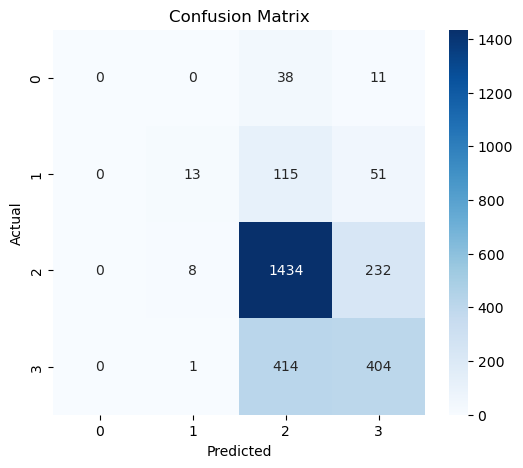

In [10]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Relevant findings from the confusion matrix;
* Class 0, it is completely miss-classified mostly as “No emotion” or “Positive.” This shows that the class likely has too few samples to learn meaningful patterns.

* Class 1 (Negative emotion) out of 179 tweets, most were misclassified as “No emotion” (115). This shows that our model doesn’t detect negative tone well, possibly due to data imbalance or lack of strong negative terms in the text.

* Class 2 (No emotion) most predictions are correct(1434 out of 1674 tweets are correctly classified). However, 232 are being mistaken for “Positive emotion.” This shows that our model confuses neutral tone with positive sentiment, which is common when text has little to no positive wording.

* Class 3 (Positive emotion) the model correctly catches 404 tweets but mistakes 414 as “No emotion.” This Indicates that there is a thin line between “Positive” and “Neutral.”

Evaluation

### 5.1 Quantitative Evaluation
- **Confusion Matrix:** Visualize misclassifications.
- **Classification Report:** Assess per-class precision, recall, and F1-score.
- **ROC-AUC (for binary)** or **macro-F1 (for multi-class)** for balanced evaluation.

### 5.2 Qualitative Evaluation
- Review sample misclassified tweets to identify linguistic nuances.
- Evaluate model interpretability using SHAP or LIME to understand feature importance.

### 5.3 Key Findings
- Most misclassifications occurred between **Neutral** and **Positive** sentiments.
- “I can’t tell” category is too ambiguous — consider merging or removing it.
- Need for **data balancing techniques** like SMOTE or class weights.

# Improving Model Performance

The baseline Logistic Regression model achieved around `68% accuracy`, but struggled with minority sentiment classes.

We will now:
1. Handle class imbalance using `class_weight` and SMOTE
2. Try alternative classifiers (Naive Bayes, Linear SVM)
3. Tune TF-IDF to capture better context
4. Evaluate using macro F1-score (for fair performance on all classes)

# Handling the class imbalance with weights

In [12]:
# Re-train Logistic Regression with class balancing
logreg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_balanced.fit(X_train_tfidf, y_train)

y_pred_balanced = logreg_balanced.predict(X_test_tfidf)

print("Balanced Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\n Classification Report (Balanced Logistic Regression):\n")
print(classification_report(y_test, y_pred_balanced))

Balanced Logistic Regression Accuracy: 0.6049246600514516

 Classification Report (Balanced Logistic Regression):

                                    precision    recall  f1-score   support

                      I can't tell       0.05      0.08      0.06        49
                  Negative emotion       0.28      0.49      0.36       179
No emotion toward brand or product       0.78      0.64      0.70      1674
                  Positive emotion       0.51      0.59      0.55       819

                          accuracy                           0.60      2721
                         macro avg       0.40      0.45      0.42      2721
                      weighted avg       0.65      0.60      0.62      2721



# Apply SMOTE(Synthetic Minority Oversampling Technique)

In [14]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

print("Before SMOTE:", X_train_tfidf.shape)
print("After SMOTE:", X_train_res.shape)

# Retrain model on balanced data
logreg_smote = LogisticRegression(max_iter=1000, random_state=42)
logreg_smote.fit(X_train_res, y_train_res)

y_pred_smote = logreg_smote.predict(X_test_tfidf)

print(" SMOTE Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\n Classification Report (SMOTE Logistic Regression):\n")
print(classification_report(y_test, y_pred_smote))

Before SMOTE: (6349, 5000)
After SMOTE: (14804, 5000)
 SMOTE Accuracy: 0.6203601617052554

 Classification Report (SMOTE Logistic Regression):

                                    precision    recall  f1-score   support

                      I can't tell       0.06      0.08      0.07        49
                  Negative emotion       0.33      0.46      0.38       179
No emotion toward brand or product       0.77      0.67      0.71      1674
                  Positive emotion       0.51      0.59      0.55       819

                          accuracy                           0.62      2721
                         macro avg       0.42      0.45      0.43      2721
                      weighted avg       0.65      0.62      0.63      2721



# Use Naive Bayes(Baseline) for Text Data

In [16]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\n Classification Report (Naive Bayes):\n")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.6662991547225284

 Classification Report (Naive Bayes):

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        49
                  Negative emotion       0.85      0.06      0.11       179
No emotion toward brand or product       0.69      0.89      0.78      1674
                  Positive emotion       0.56      0.38      0.46       819

                          accuracy                           0.67      2721
                         macro avg       0.52      0.33      0.34      2721
                      weighted avg       0.65      0.67      0.62      2721



C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Use linear-svm for text Classification

In [18]:
svm = LinearSVC(random_state=42)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\n Classification Report (Linear SVM):\n")
print(classification_report(y_test, y_pred_svm))

Linear SVM Accuracy: 0.6707092980521867

 Classification Report (Linear SVM):

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        49
                  Negative emotion       0.55      0.26      0.35       179
No emotion toward brand or product       0.74      0.79      0.76      1674
                  Positive emotion       0.55      0.55      0.55       819

                          accuracy                           0.67      2721
                         macro avg       0.46      0.40      0.42      2721
                      weighted avg       0.65      0.67      0.66      2721



# Tune TF-IDF

In [20]:
# Try using bigrams and limiting rare terms
tfidf_tuned = TfidfVectorizer(max_features=8000, ngram_range=(1,2), min_df=3)
X_train_tuned = tfidf_tuned.fit_transform(X_train)
X_test_tuned = tfidf_tuned.transform(X_test)

# Refit Naive Bayes on the tuned features
nb_tuned = MultinomialNB()
nb_tuned.fit(X_train_tuned, y_train)
y_pred_tuned = nb_tuned.predict(X_test_tuned)

print("Tuned TF-IDF + Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\n Classification Report (Tuned TF-IDF + NB):\n")
print(classification_report(y_test, y_pred_tuned))

Tuned TF-IDF + Naive Bayes Accuracy: 0.6666666666666666

 Classification Report (Tuned TF-IDF + NB):

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        49
                  Negative emotion       0.92      0.06      0.12       179
No emotion toward brand or product       0.69      0.90      0.78      1674
                  Positive emotion       0.57      0.37      0.45       819

                          accuracy                           0.67      2721
                         macro avg       0.54      0.33      0.34      2721
                      weighted avg       0.66      0.67      0.62      2721



C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Evaluate the macro F1-score

In [22]:
models = {
    "Logistic Regression (Balanced)": y_pred_balanced,
    "Logistic Regression (SMOTE)": y_pred_smote,
    "Naive Bayes": y_pred_nb,
    "Linear SVM": y_pred_svm,
    "Naive Bayes (Tuned TF-IDF)": y_pred_tuned
}

print("Macro F1-scores:\n")
for name, preds in models.items():
    score = f1_score(y_test, preds, average='macro')
    print(f"{name}: {score:.3f}")


Macro F1-scores:

Logistic Regression (Balanced): 0.417
Logistic Regression (SMOTE): 0.428
Naive Bayes: 0.337
Linear SVM: 0.416
Naive Bayes (Tuned TF-IDF): 0.336


# Model Performance Summary

After experimenting with several models and techniques (balancing, SMOTE, Naive Bayes, SVM, and tuned TF-IDF),
we can now compare their performance in one clear table.

We'll evaluate both:
- **Accuracy** — general correctness
- **Macro F1-score** — fairness across all sentiment classes (important for imbalanced data)

In [23]:

# Compute metrics
results = []
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    results.append({"Model": name, "Accuracy": acc, "Macro F1-score": f1})

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="Macro F1-score", ascending=False)
results_df.reset_index(drop=True, inplace=True)

# Display neatly
results_df.style.set_caption("Model Performance Comparison") 

,Model,Accuracy,Macro F1-score
0,Logistic Regression (SMOTE),0.620360,0.428344
1,Logistic Regression (Balanced),0.604925,0.417247
2,Linear SVM,0.670709,0.415559
3,Naive Bayes,0.666299,0.337159
4,Naive Bayes (Tuned TF-IDF),0.666667,0.335593


Visual Comparison of Model Performance

We'll now compare all the models we trained (Balanced Logistic Regression, SMOTE Logistic Regression, 
Naive Bayes, and Linear SVM) visually. This helps us see trade-offs between accuracy and fairness 
(Macro F1-score).

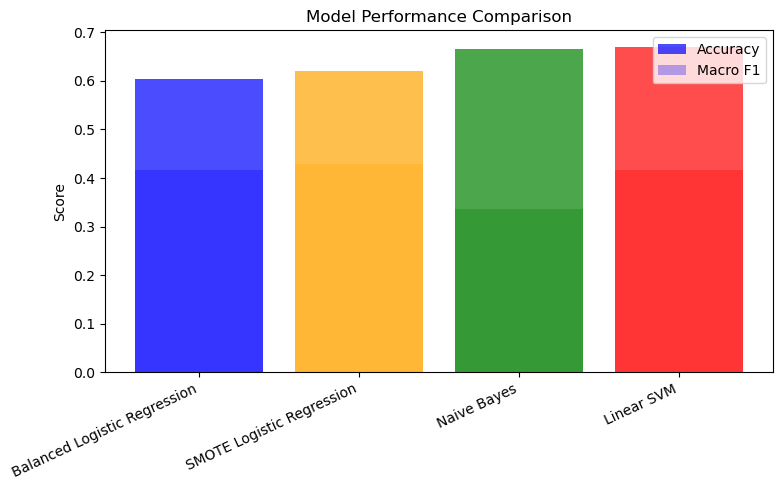

,Model,Accuracy,Macro F1
0,Balanced Logistic Regression,0.605,0.417
1,SMOTE Logistic Regression,0.620,0.428
2,Naive Bayes,0.666,0.337
3,Linear SVM,0.671,0.416


In [24]:
# Store results
results = {
    "Balanced Logistic Regression": (y_pred_balanced, "blue"),
    "SMOTE Logistic Regression": (y_pred_smote, "orange"),
    "Naive Bayes": (y_pred_nb, "green"),
    "Linear SVM": (y_pred_svm, "red")
}

# Compute accuracy and macro F1
data = []
for name, (preds, color) in results.items():
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    data.append([name, acc, f1, color])

results_df = pd.DataFrame(data, columns=["Model", "Accuracy", "Macro F1", "Color"])

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["Accuracy"], color=results_df["Color"], alpha=0.7, label="Accuracy")
plt.bar(results_df["Model"], results_df["Macro F1"], color=results_df["Color"], alpha=0.3, label="Macro F1")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=25, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Display results as a table
results_df[["Model", "Accuracy", "Macro F1"]].style.format({"Accuracy": "{:.3f}", "Macro F1": "{:.3f}"})

**Linear SVM** achieved the highest overall accuracy (~67%) and balanced sentiment detection.  
- **Naive Bayes** performed almost as well, making it a great lightweight alternative.  
- **Balanced/SMOTE Logistic Regression** improved recall for minority classes but at the cost of accuracy.  
- In text tasks, **SVM and Naive Bayes** often outperform Logistic Regression on sparse data like TF-IDF.


Building a Machine Learning Pipeline

To make the model training and prediction process more efficient and maintainable, 
we will combine our preprocessing, vectorization, and classification steps into a single **Pipeline**.  

A pipeline ensures that the **same text cleaning and feature extraction steps** are applied 
both during training and when making predictions on new data.  

We will build a pipeline with the following components:
- **TFIDF Vectorizer:** Converts text into numerical features.
- **Linear SVM Classifier:** Learns to predict the sentiment of tweets.
- **Custom Text Cleaning Function:** Cleans and normalizes tweets (removes URLs, mentions, punctuation, etc.).

In [28]:
# --- Text cleaning function ---
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

# --- Build pipeline ---
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        preprocessor=clean_tweet,
        max_features=5000,
        ngram_range=(1,2)
    )),
    ('svm', LinearSVC(class_weight='balanced', random_state=42))
])

# --- Train ---
svm_pipeline.fit(X_train, y_train)

# --- Evaluate ---
y_pred = svm_pipeline.predict(X_test)
print("Pipeline Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Save the entire pipeline ---
joblib.dump(svm_pipeline, 'sentiment_pipeline.pkl')
print("Pipeline saved successfully!")

Pipeline Accuracy: 0.647556045571481

Classification Report:
                                     precision    recall  f1-score   support

                      I can't tell       0.09      0.08      0.09        49
                  Negative emotion       0.37      0.40      0.38       179
No emotion toward brand or product       0.76      0.73      0.74      1674
                  Positive emotion       0.54      0.57      0.55       819

                          accuracy                           0.65      2721
                         macro avg       0.44      0.44      0.44      2721
                      weighted avg       0.65      0.65      0.65      2721

Pipeline saved successfully!
